In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from google.colab import drive
import os
drive.mount('/content/gdrive/')

%cd /content/gdrive/My\ Drive/GAN/64

Found GPU at: /device:GPU:0
Mounted at /content/gdrive/
/content/gdrive/My Drive/GAN/64


In [2]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential


def generador_de_imagenes():

    generador = Sequential()

    generador.add(Dense(256*8*8, input_shape=(100,)))
    generador.add(BatchNormalization())
    generador.add(LeakyReLU())

    generador.add(Reshape((8, 8, 256)))

    generador.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
    generador.add(BatchNormalization())
    generador.add(LeakyReLU())

    generador.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"))
    generador.add(BatchNormalization())
    generador.add(LeakyReLU())

    generador.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding="same"))
    generador.add(BatchNormalization())
    generador.add(LeakyReLU())

    generador.add(Conv2DTranspose(3, kernel_size=3, padding="same", activation='tanh'))

    return generador

modelo_generador = generador_de_imagenes()

modelo_generador.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      295040    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      5

1/1 [==============================] - 9s 9s/step


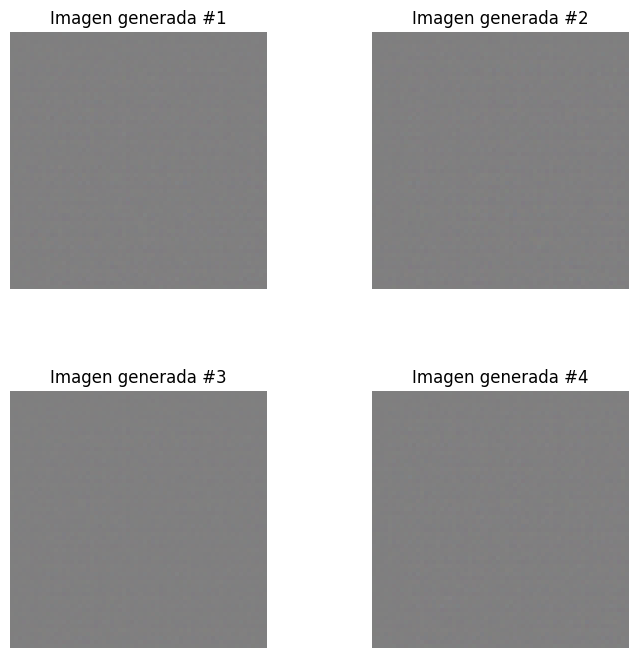

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Definir datos de entrada
def generar_datos_entrada(n_muestras):
  X = np.random.randn(100 * n_muestras)
  X = X.reshape(n_muestras, 100)
  return X

def crear_datos_fake(modelo_generador, n_muestras):
  input = generar_datos_entrada(n_muestras)
  X = modelo_generador.predict(input)
  y = np.zeros((n_muestras, 1))
  return X, y

numero_muestras = 4
X, _ = crear_datos_fake(modelo_generador, numero_muestras)

# Visualizamos resultados
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axs = axs.ravel()

for i in range(numero_muestras):
    axs[i].imshow((X[i] + 1) / 2)
    axs[i].axis('off')
    axs[i].set_title('Imagen generada #' + str(i+1))

plt.show()


In [4]:
from keras.layers import Conv2D, Flatten, Dropout
from keras.optimizers import Adam

def discriminador_de_imagenes():

    discriminador = Sequential()
    discriminador.add(Conv2D(64, kernel_size=3, padding = "same", input_shape = (64,64,3)))
    discriminador.add(LeakyReLU(alpha=0.2))
    
    discriminador.add(Conv2D(64, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    discriminador.add(Dropout(0.4))
    
    discriminador.add(Conv2D(128, kernel_size=3,strides=(1,1), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    
    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    discriminador.add(Dropout(0.4))
    
    discriminador.add(Conv2D(256, kernel_size=3,strides=(1,1), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    
    discriminador.add(Conv2D(256, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    discriminador.add(Dropout(0.4))
    
    discriminador.add(Conv2D(512, kernel_size=3,strides=(1,1), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    
    discriminador.add(Conv2D(512, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    discriminador.add(Dropout(0.4))
    
    discriminador.add(Flatten())
    discriminador.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002 ,beta_1=0.5)
    discriminador.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminador)

modelo_discriminador = discriminador_de_imagenes()
modelo_discriminador.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 128)      

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [5]:
import numpy as np
import cv2
import os

def cargar_imagenes():
    ruta_carpeta = '/content/gdrive/My Drive/GAN/celeba'
    imagenes = []

    for archivo in os.listdir(ruta_carpeta):
        ruta_archivo = os.path.join(ruta_carpeta, archivo)
        imagen = cv2.imread(ruta_archivo)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB) # Cambiar el orden de los canales de color
        imagen = cv2.resize(imagen, (64, 64)) # Redimensionar la imagen
        imagenes.append(imagen)

    # Convertir la lista de imágenes a un array de numpy y normalizarlo
    X = np.array(imagenes).astype('float32')
    X = (X - 127.5) / 127.5

    return X


print(cargar_imagenes().shape)

(300, 64, 64, 3)


In [6]:
import random

def cargar_datos_reales(dataset, n_muestras):
  ix = np.random.randint(0, dataset.shape[0], n_muestras)
  X = dataset[ix]
  y = np.ones((n_muestras, 1))
  return X,y

def cargar_datos_fake(n_muestras):
  X = np.random.randn(n_muestras, 64, 64, 3)
  y = np.zeros((n_muestras, 1))
  return X, y




In [7]:
def entrenar_discriminador(modelo, dataset, epochs=50, batch=128):
    medio_batch = int(batch/2)
    num_batches = int(dataset.shape[0] / batch)
    acc_real_hist = []
    acc_fake_hist = []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        acc_real_ep = []
        acc_fake_ep = []
        for i in range(num_batches):
            X_real, y_real = cargar_datos_reales(dataset, medio_batch)
            _, acc_real = modelo.train_on_batch(X_real, y_real)
            acc_real_ep.append(acc_real)
            
            X_fake, y_fake = cargar_datos_fake(medio_batch)
            _, acc_fake = modelo.train_on_batch(X_fake, y_fake)
            acc_fake_ep.append(acc_fake)
            
        print(f'Real: {np.mean(acc_real_ep)*100:.2f}%, Fake: {np.mean(acc_fake_ep)*100:.2f}%')
        acc_real_hist.append(np.mean(acc_real_ep))
        acc_fake_hist.append(np.mean(acc_fake_ep))
    
    return acc_real_hist, acc_fake_hist


In [8]:
dataset = cargar_imagenes()
entrenar_discriminador(modelo_discriminador, dataset)

Epoch 1/50
Real: 53.91%, Fake: 0.00%
Epoch 2/50
Real: 77.34%, Fake: 83.59%
Epoch 3/50
Real: 34.38%, Fake: 100.00%
Epoch 4/50
Real: 60.94%, Fake: 100.00%
Epoch 5/50
Real: 100.00%, Fake: 100.00%
Epoch 6/50
Real: 100.00%, Fake: 100.00%
Epoch 7/50
Real: 100.00%, Fake: 100.00%
Epoch 8/50
Real: 100.00%, Fake: 100.00%
Epoch 9/50
Real: 100.00%, Fake: 100.00%
Epoch 10/50
Real: 100.00%, Fake: 100.00%
Epoch 11/50
Real: 100.00%, Fake: 100.00%
Epoch 12/50
Real: 100.00%, Fake: 100.00%
Epoch 13/50
Real: 100.00%, Fake: 100.00%
Epoch 14/50
Real: 100.00%, Fake: 100.00%
Epoch 15/50
Real: 100.00%, Fake: 100.00%
Epoch 16/50
Real: 100.00%, Fake: 100.00%
Epoch 17/50
Real: 100.00%, Fake: 100.00%
Epoch 18/50
Real: 100.00%, Fake: 100.00%
Epoch 19/50
Real: 100.00%, Fake: 100.00%
Epoch 20/50
Real: 100.00%, Fake: 100.00%
Epoch 21/50
Real: 100.00%, Fake: 100.00%
Epoch 22/50
Real: 100.00%, Fake: 100.00%
Epoch 23/50
Real: 100.00%, Fake: 100.00%
Epoch 24/50
Real: 100.00%, Fake: 100.00%
Epoch 25/50
Real: 100.00%, Fake:

([0.5390625,
  0.7734375,
  0.34375,
  0.609375,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [0.0,
  0.8359375,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0])

In [9]:
def crear_gan(discriminador, generador):
    discriminador.trainable=False
    gan = Sequential()
    gan.add(generador)
    gan.add(discriminador)

    opt = Adam(lr=0.0003,beta_1=0.5) 
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan

gan = crear_gan(modelo_discriminador,modelo_generador)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         2109379   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 4693569   
                                                                 
Total params: 6,802,948
Trainable params: 2,076,163
Non-trainable params: 4,726,785
_________________________________________________________________


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

def mostrar_imagenes_generadas(datos_fake, epoch):

  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  # Hacemos que los datos vayan de 0 a 1
  datos_fake = (datos_fake + 1) / 2.0

  for i in range(10):
    plt.imshow(datos_fake[i])
    plt.axis('off')
    nombre = str(epoch) + '_imagen_generada_' + str(i) + '.png'
    plt.savefig(nombre, bbox_inches='tight')
    


In [11]:
def evaluar_y_guardar(modelo_generador, epoch, medio_dataset):

  # Guardamos el modelo
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  nombre = str(epoch) + '_' + str(now)+"_modelo_generador_" + '.h5'
  modelo_generador.save(nombre)

  # Generamos nuevos datos
  X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)
  X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)

  # Evaluamos el modelo
  _, acc_real = modelo_discriminador.evaluate(X_real, Y_real)
  _, acc_fake = modelo_discriminador.evaluate(X_fake, Y_fake)

  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')

In [16]:
def entrenamiento(datos, modelo_generador, modelo_discriminador, epochs, n_batch, inicio = 0):
  dimension_batch = int(datos.shape[0]/n_batch)
  medio_dataset = int(n_batch/2)

  # Iteramos para todos los epochs
  for epoch in range(inicio, inicio + epochs):
    # Iteramos para todos los batches
    for batch in range(n_batch):

      # Cargamos datos reales
      X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)


      # Enrenamos discriminador con datos reales
      coste_discriminador_real, _ = modelo_discriminador.train_on_batch(X_real, Y_real)
      X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)

      coste_discriminador_fake, _ = modelo_discriminador.train_on_batch(X_fake, Y_fake)

      # Generamos datos de entadas de la GAN
      X_gan = generar_datos_entrada(medio_dataset)
      Y_gan = np.ones((medio_dataset, 1))

      # Entrenamos la GAN con datos falsos
      coste_gan = gan.train_on_batch(X_gan, Y_gan)

    print('Epoch:' + str(epoch))
    # Cada 10 Epochs mostramos resultados y el coste
    if (epoch+1) % 10 == 0:
      evaluar_y_guardar(modelo_generador,epoch = epoch, medio_dataset= medio_dataset)
      mostrar_imagenes_generadas(X_fake, epoch = epoch)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
2/2 [==============================] - 0s 10ms/step
Epoch:253
2/2 [==============================] - 0s 5ms/step
Epoch:254
2/2 [==============================] - 0s 14ms/step
Epoch:255
2/2 [==============================] - 0s 12ms/step
Epoch:256
2/2 [==============================] - 0s 11ms/step
Epoch:257
2/2 [==============================] - 0s 14ms/step
Epoch:258
2/2 [==============================] - 0s 6ms/step
Epoch:259
2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:100.0% Acc Fake:100.0%
2/2 [==============================] - 0s 14ms/step
Epoch:260
2/2 [==============================] - 0s 7ms/step
Epoch:261
2/2 [==============================] - 0s 7ms/step
Epoch:262
2/2 [==============================] - 0s 12ms/step
Epoch:263
2/2 [==============================] - 0s 15ms/step
Epoch:264
2/2 [==============================] - 0s 15ms/step
Epoch:265
2/2 [====

KeyboardInterrupt: ignored

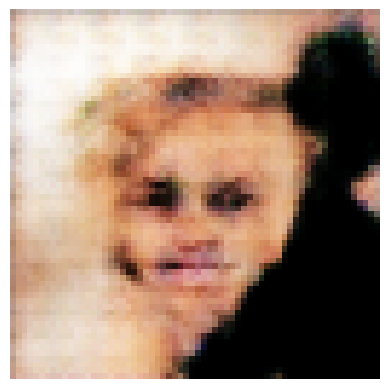

In [17]:
entrenamiento(dataset, modelo_generador, modelo_discriminador, epochs = 1000, n_batch=128, inicio = 0)

2/2 [==============================] - 0s 6ms/step


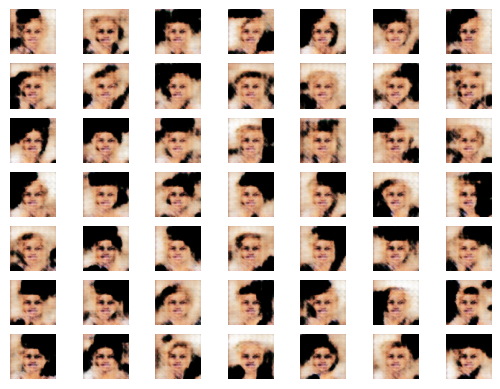

In [18]:
X_fake, _ = crear_datos_fake(n_muestras=49, modelo_generador=modelo_generador)
X_fake = (X_fake+1)/2

for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(X_fake[i])

In [14]:
# 2. Importamos el modelo
from keras.models import load_model

modelo_generador = load_model('99_20230401_071624_modelo_generador_.h5')


In [13]:
modelo_generador.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])